# Deep Learning with PyTorch : Build a Generative Adversarial Network

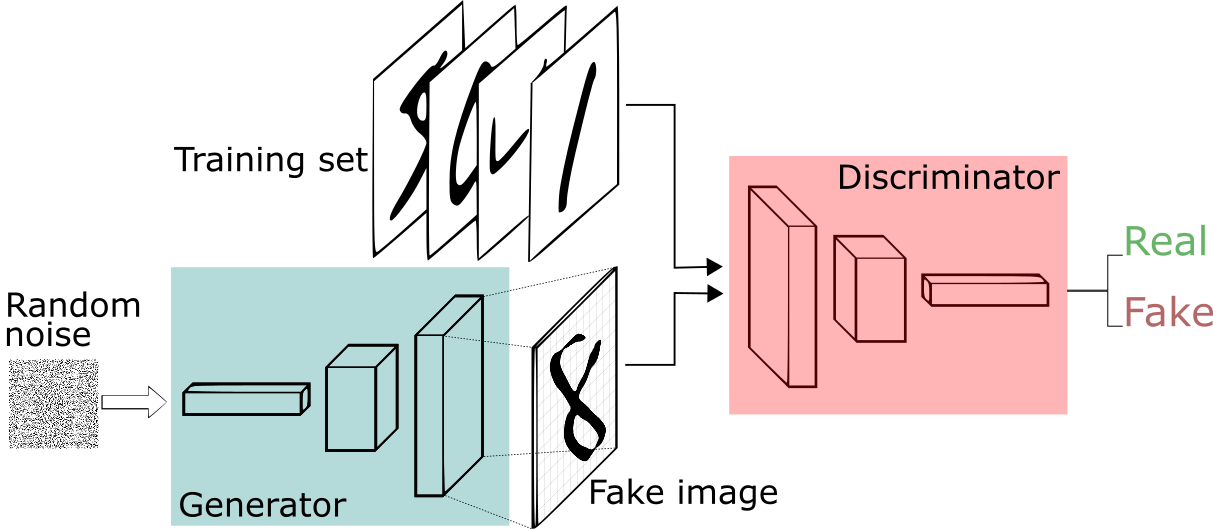

In [297]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [298]:
device = "cuda"     # Make sure is GPU use
batch_size = 128    # This is used in the trainloader and training loop
noise_dim = 64      # Random noise vector used by the generator model to create "fake" numbers

# Optimizing parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20       

# Load MNIST Dataset

Declaration of the transformation process and load of the data

In [299]:
from torchvision import datasets, transforms as T

In [300]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)),   # To make image detection insensitive to possible rotations of the image
    T.ToTensor()                 # Images arrays to tensor object
    ])

In [301]:
trainset = datasets.MNIST("MNIST/", download=True, train=True, transform=train_augs)

Label is: 0


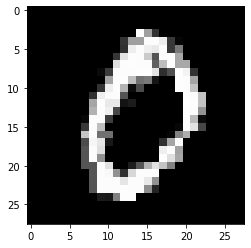

In [302]:
image, label = trainset[1]                   # Load an image example
plt.imshow(image.squeeze(), cmap="gray")     # Print it with its label
print('Label is:',label)

# Load Dataset Into Batches

In [303]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [304]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
print("Total number of batches in trainloader:", len(trainloader))

Total number of batches in trainloader: 469


In [305]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [306]:
# 'show_tensor_images' : function is used to plot some of the images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

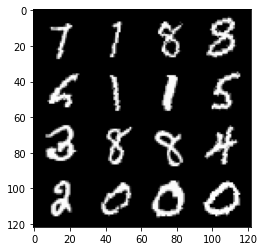

tensor([7, 1, 8, 8, 6, 1, 1, 5, 3, 8, 8, 4, 2, 0, 0, 0])


In [307]:
show_tensor_images(images, num_images=16)
print(labels[0:16])

# Create Discriminator Network

The discriminator network will be able once trained (hopefully!) to discriminate fake images from real ones. It is actually pretty simple to build, let Gerardo show you. This is the structure of the NN, that takes as an input an array-represented image and the output is a probability:

In [308]:
from torch import nn
from torchsummary import summary

In this schema you can see that our input is a image. The batch size is 1 color dimension (1 channel, grey-scale) and 28x28 resolution. The convolutional network will reduce the dimension of the resolution while capturing abstract channels/features and non-linear patters. Each section is based on 3 layers: 

* The Convd2() layer performs a 2-dimensional convolution over a kernel of 3x3 pixels (moving in each iteration through a sparse of 2 pixels), extracting their relevant features/complex image patterns. Each neuron produces a 13x13 feature map (16 neurons, producing 1 channel each)
* The BatchNorm function performs a normalization (and a regularization) of the training process, making sure it stays stable to variations in the input data
* The use of a leaky function (LeakyReLU) instead of a regular ReLU is used to avoid the "Dying ReLU problem", which appears when negative values produce neurons start becoming inactive and simply generating 0's as outputs (thus, not contributing to the backpropagation).


Finally,the output geneartion is based on 2 layers:

* The Flatten() layer simply creates a one-dimensional tensor
* The Linear() final layer reduces to a single value the whole process. It also performs a sigmoid activation (when we define the CrossEntropy) to generate the probability that will tell us if our image seems real or fake

In [309]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [310]:
# Each block of layers can be build with this created function

def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [311]:
# We simply now design objects that create the NN we desire as well as define the forward process

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, images):
        x = self.block_1(images)
        x = self.block_2(x)
        x = self.block_3(x)

        x = self.flatten(x)
        x = self.linear(x)
        return x
    

In [312]:
D = Discriminator()


summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

This GAN will try to create fake iamges that can try to fool our discriminator by creating fake images. This is its architecture, that as you can see is very simmilar to our discriminator. . There are only some little differences: 

* Input is including now a noise vector with multiple dimensions!
* Output should be images of 28x28 pixels where each pixel has values betweeen -1 to 1. That is why we use the activation Tahn-layer :)

In [313]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [314]:
def get_gen_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )


def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block==True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )


    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )



In [315]:
# We simply now design objects that create the NN we desire as well as define the forward process

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        
        self.tran = nn.ConvTranspose2d(64, 1, (4,4), 2)
        self.tahn = nn.Tanh()
        
    def forward(self, r_noise_vr):
        x = r_noise_vr.view(-1, self.noise_dim, 1, 1)   # Change input dimensions 
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)

        x = self.tran(x)
        x = self.tahn(x)
        return x
    

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        self.block_4 = get_gen_block(64,1,(4,4), 2, final_block=True)
        
    def forward(self, r_noise_vr):
        x = r_noise_vr.view(-1, self.noise_dim, 1, 1)   # Change input dimensions 
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
     
        return x
    

In [316]:
G = Generator(noise_dim)


summary(G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## Replace initial weights for both models

In [317]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [318]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

The loss is calculated by comparing disc_pred (the discriminator's predictions) with the ground truth labels (ones). The loss quantifies the difference between the predicted values and the true labels. The aim is to minimize this loss during training. The criterion for the loss function is BCEWithLogitsLoss (Binary Classification Entropy). 

And why are we defining two losses, one for the real data and another for the fake one? Simply because our models should use different ones. It enables the discriminator and generator to focus on their respective tasks:

* The discriminator aims to minimize both, the summation of the real_loss and fake_loss simultaneously during training. This means that it tries to become better at distinguishing both real and fake data.
* The generator uses the output of the discriminator (specifically, fake_loss) as feedback to adjust its parameters. The generator's goal is to generate data that the discriminator is more likely to classify as real, i.e., to minimize fake_loss.

In [319]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)   # Probability is 1 (real image)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)  # Probability is 0 (fake image)
    loss = criterion(disc_pred, ground_truth)
    return loss

Now we simply define the optimizers. The very standard Adam is the one I decided to use

In [320]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas= (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas= (beta_1, beta_2))

noise = torch.randn(batch_size, noise_dim)
fake_img = G(noise)
print(noise)
print(fake_img)

tensor([[ 0.5544, -0.1409,  0.0602,  ...,  1.7234, -1.1948,  1.1611],
        [-1.8329,  0.0901,  0.9006,  ..., -0.0766,  0.5868, -1.3235],
        [-0.5719, -0.7739, -0.6235,  ...,  0.6804,  0.3690, -1.1746],
        ...,
        [-0.2946, -1.5193, -2.0388,  ..., -0.1303, -0.1430, -0.6896],
        [ 0.6441, -0.2245,  1.2581,  ..., -0.8835, -0.1279,  0.1652],
        [-0.6729, -1.9563,  1.5861,  ...,  0.2077, -0.5180, -1.7546]])
tensor([[[[0.1961, 0.1954, 0.1969,  ..., 0.1965, 0.1949, 0.1966],
          [0.1945, 0.1953, 0.1947,  ..., 0.1939, 0.1956, 0.1957],
          [0.1961, 0.1946, 0.1966,  ..., 0.1992, 0.1940, 0.1974],
          ...,
          [0.1955, 0.1952, 0.1930,  ..., 0.1940, 0.1967, 0.1959],
          [0.1956, 0.1954, 0.1961,  ..., 0.1964, 0.1948, 0.1965],
          [0.1948, 0.1949, 0.1949,  ..., 0.1945, 0.1951, 0.1952]]],


        [[[0.1958, 0.1955, 0.1968,  ..., 0.1979, 0.1940, 0.1970],
          [0.1951, 0.1958, 0.1952,  ..., 0.1926, 0.1960, 0.1949],
          [0.1964, 

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1, | D_loss: 0.6645708883494965 | G_loss: 0.7112304915243121


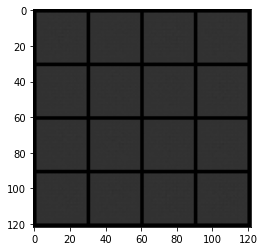

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2, | D_loss: 0.5641607826452519 | G_loss: 0.842962786205796


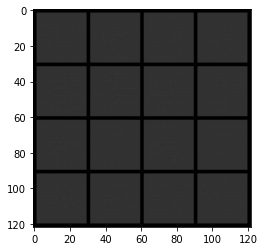

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3, | D_loss: 0.4306104805932116 | G_loss: 1.054890673806164


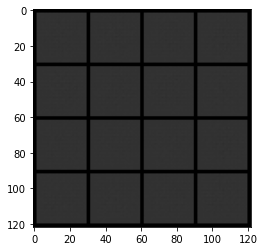

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4, | D_loss: 0.29540599501336307 | G_loss: 1.371545598705186


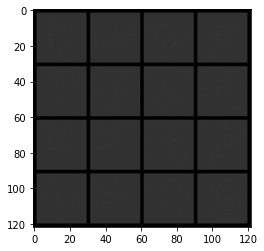

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [321]:
for i in range(epochs):
    total_D_loss = 0.0 
    total_G_loss = 0.0 

    for real_img, label in tqdm(trainloader):        # TQDM just is a visual feature to show the progession of the loop
        
        noise = torch.randn(batch_size, noise_dim)

        # Calculate loss and update weights for D
        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2
        total_D_loss += D_loss.item()
        
        D_loss.backward()
        D_opt.step()

        # Calculate loss and update weights for G
        G_opt.zero_grad()
        
        noise = torch.randn(batch_size, noise_dim)
        
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)                # Remember that the Generator wants to be able to trick the Discriminator!

        total_G_loss += G_loss.item()

        G_loss.backward()
        G_opt.step
    
    avg_D_loss = total_D_loss / len(trainloader)
    avg_G_loss = total_G_loss / len(trainloader)
    
    # Report each iteration
    print("Epoch: {}, | D_loss: {} | G_loss: {}".format(i+1, avg_D_loss, avg_G_loss))
    show_tensor_images(fake_img) # See how fake images improve


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0.1586,  2.0585,  0.0158,  ...,  0.3107, -1.4460, -1.0011],
        [-0.3021, -0.4984, -1.1461,  ...,  0.7342, -1.7570, -2.0201],
        [ 1.3180,  0.8182, -0.6986,  ...,  0.5206,  1.5755,  0.5811],
        ...,
        [ 0.9235, -2.1774,  0.0510,  ..., -0.0365,  0.0644, -1.5616],
        [-0.8724,  0.1789, -1.4169,  ..., -0.2746,  1.0753,  1.9163],
        [-0.3378,  1.3903, -0.3767,  ..., -0.5497, -1.3113,  0.0039]])
tensor([[[[-0.1290, -0.1333, -0.1280,  ..., -0.1325, -0.1311, -0.1302],
          [-0.1295, -0.1293, -0.1264,  ..., -0.1310, -0.1302, -0.1298],
          [-0.1291, -0.1285, -0.1301,  ..., -0.1320, -0.1320, -0.1315],
          ...,
          [-0.1322, -0.1317, -0.1308,  ..., -0.1314, -0.1293, -0.1311],
          [-0.1296, -0.1289, -0.1314,  ..., -0.1285, -0.1299, -0.1312],
          [-0.1312, -0.1302, -0.1302,  ..., -0.1323, -0.1298, -0.1304]]],


        [[[-0.1298, -0.1322, -0.1286,  ..., -0.1321, -0.1313, -0.1307],
          [-0.1296, -0.1296, -0.1290,  ...,

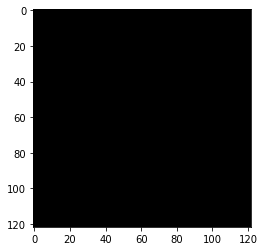

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim)
generated_image = G(noise)
show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya